In [115]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib
import re
from sklearn import preprocessing

In [116]:
filepath = './tweets.csv'

df = pd.read_csv(filepath, delimiter=',',
                skiprows=1, # skips the first line of the file
                encoding='unicode_escape', # prevents errors on unknown symbols
                usecols=['Vertex 1', 'Vertex 2', 'Tweet'], # only import the columns we use
                )
df.columns = ['source_user', 'mentioned_user', 'tweet_text']

print(df)

         source_user   mentioned_user  \
0           notherle        dude_stay   
1           notherle       facikwacik   
2           notherle     crazycold739   
3           notherle       filippecak   
4           notherle      u_yousolame   
..               ...              ...   
842     bulletking61     bulletking61   
843     mx_hippakrit     mx_hippakrit   
844  shers_wird_stuf  shers_wird_stuf   
845   fastblueapple9  shers_wird_stuf   
846     centurionfox            steam   

                                            tweet_text  
0    RT @dude_stay: Plz help us save the this game ...  
1    RT @FacikWacik: My favorite game is dying ????...  
2    RT @CraZyCold739: I associate with this game n...  
3    RT @FilipPecak: Hi people. Let's save #SafeTF2...  
4    RT @u_yousolame: I been playing tf2 for a few ...  
..                                                 ...  
842              #SafeTF2  PLZZZZZZZZZZZZZZZZZZZZZZZZZ  
843  I know I'm late for this but #SafeTF2 (':\n\nh

In [117]:
# add nodes? first export df to list/dictionary then transform? or easier way?

In [118]:
G = nx.DiGraph()
colors = []
for source_user, mentioned_user, tweet_text in zip(df.source_user, df.mentioned_user, df.tweet_text):

    if source_user != mentioned_user:
        G.add_edge(source_user, mentioned_user)
        if "RT" in tweet_text[:3]:
            colors.append("black")
        else:
            colors.append("red")

node_colors = np.arange(0.0, 1.0, 1/G.number_of_nodes())
print(len(node_colors))

344


In [119]:
G.number_of_nodes()

344

In [120]:
G.number_of_edges()

434

In [121]:
measures = {"centrality": {'in_degree': nx.in_degree_centrality(G), 'out_degree': nx.out_degree_centrality(G),
                           'betweenness': nx.betweenness_centrality(G), 'closeness': nx.closeness_centrality(G)}}
out_degrees = []
for key, value in nx.out_degree_centrality(G).items():
    out_degrees.append(value)

minima = min(out_degrees)
maxima = max(out_degrees)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greys_r)
node_colors = []
for v in out_degrees:
    node_colors.append(mapper.to_rgba(v)[0])


In [122]:
def print_max(persons):
    max_word = max(persons, key=persons.get)
    print(max_word, persons[max_word])

# Analyze the network
I_words = ["i", "me", "my", "mine"]
you_words = ["you", "yours"]
we_words = ["we", "us", "our", "ours"]

# Calculate per person
persons_i_words = dict()
persons_you_words = dict()
persons_we_words = dict()
tweets_person = dict()
words_person = dict()
for index, row in df.iterrows():
    # count tweets per person
    tweets_person[row['source_user']] = tweets_person.get(row['source_user'], 0) + 1
    
    #split the text on punctuation. 
    split_text = re.split(r'[,;!?:" .\']', row['tweet_text'])
    for word in split_text:
        # count words per person
        words_person[row['source_user']] = words_person.get(row['source_user'], 0) + 1
        
        # count i/you/we words per person
        if word.lower() == 'i':
            persons_i_words[row['source_user']] = persons_i_words.get(row['source_user'], 0) + 1
        elif word.lower() == 'you':
            persons_you_words[row['source_user']] = persons_you_words.get(row['source_user'], 0) + 1
        elif word.lower() == 'we':
            persons_we_words[row['source_user']] = persons_we_words.get(row['source_user'], 0) + 1
print_max(persons_i_words)
print_max(persons_you_words)
print_max(persons_we_words)

# Make a complete dictionary with all scores for analyzing
complete_person = dict()
for person, value in words_person.items():
    complete_person[person] = {}
    complete_person[person]['words'] = value

for person, value in persons_i_words.items():
    complete_person[person]['i_words'] = value
for person, value in persons_you_words.items():
    complete_person[person]['you_words'] = value
for person, value in persons_we_words.items():
    complete_person[person]['we_words'] = value
for person, value in tweets_person.items():
    complete_person[person]['num_tweets'] = value


# Calculate proportions for i/you/we words
for key, value in complete_person.items():   
    if 'i_words' in complete_person[key]:
        complete_person[key]['%_i'] = round(complete_person[key]['i_words']/complete_person[key]['words'], 4)
    else:
        complete_person[key]['%_i'] = 0.0

    if 'you_words' in complete_person[key]:
        complete_person[key]['%_you'] = round(complete_person[key]['you_words']/complete_person[key]['words'], 4)
    else:
        complete_person[key]['%_you'] = 0.0

    if 'we_words' in complete_person[key]:
        complete_person[key]['%_we'] = round(complete_person[key]['we_words']/complete_person[key]['words'], 4)
    else:
        complete_person[key]['%_we'] = 0.0


simon_word 45
simon_word 5
simon_word 9


In [123]:
# Generate linguisticstatus scores
values = []
for key, value in complete_person.items():
    i = complete_person[key]['%_i']
    you = complete_person[key]['%_you']
    we = complete_person[key]['%_we']
    try: 
        lingstat = (you + we) / i
    except ZeroDivisionError: 
        lingstat = you + we
    complete_person[key]['lingstat'] = lingstat
    values.append(lingstat)

# Calculate the normalized lingstat values
mini = min(values)
maxi = max(values)
normalized = []
for value in values:
    x = value/maxi
    if x > 1:
       print(x)
    normalized.append(x)

# Add the normalized lingstat values back to the dictionary
for key in complete_person:
    normal = normalized.pop(0)
    complete_person[key]['lingstat'] = normal



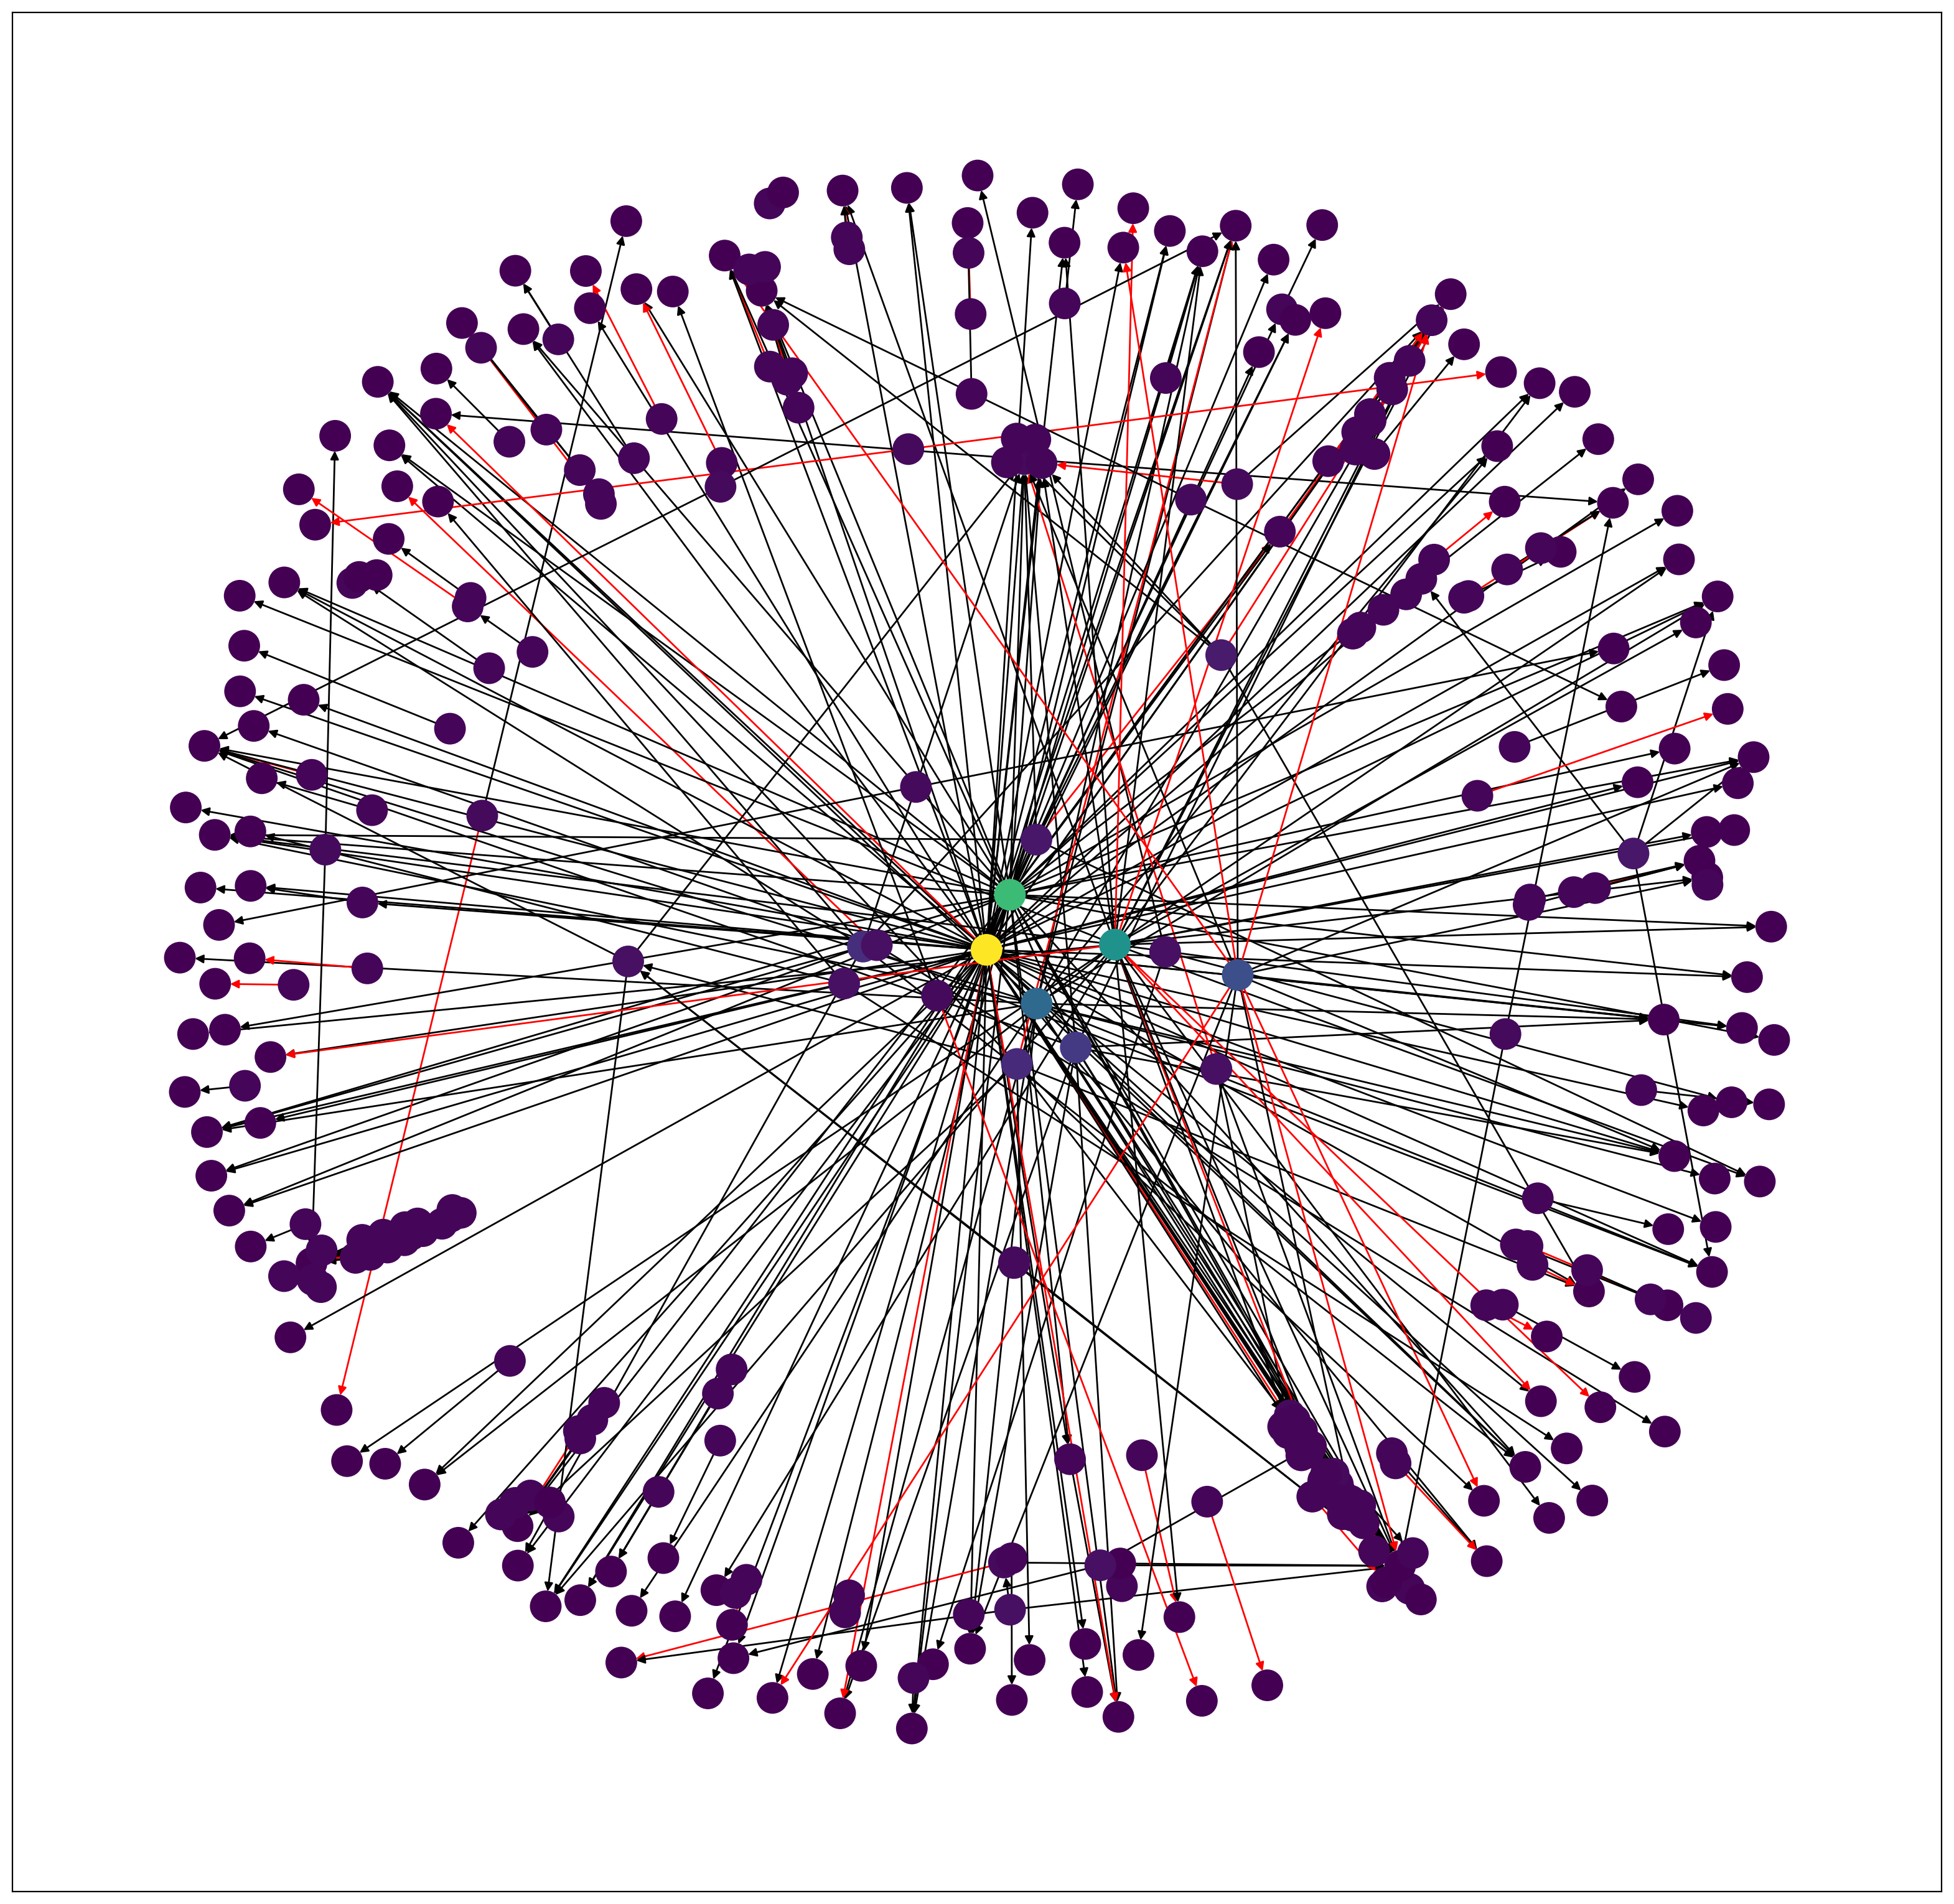

In [124]:
plt.figure(figsize=(20, 20), dpi= 200)
nx.draw_networkx(G= G, edge_color=colors, node_color=node_colors, with_labels=False)

In [127]:
# Other centrality measure
eigenvector = nx.eigenvector_centrality(G)
G.remove_node('kite__')
max_eigen = max(eigenvector.values())
print(eigenvector.values())
print(eigenvector)
# The users 'kite__' and 'hotgrossdog' have abnormally high 

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')